
# Analysis Notebook

This notebook can be used to produce graphs and analyses for the data produced. It defaults to using the latest results, but that can be specified. 
*** 

## 0. Setup
This section imports all files and sets up the notebook.

In [130]:
# Import all pacakges
%matplotlib widget
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import src.utils as utils

In [131]:
# Choose which results to use
file_to_use = "" # If this is empty, the last file in the folder will be used
last_file = sorted(os.listdir('results/'))[-1]

if file_to_use == "":
    file_to_use = last_file
    
print("Using file: " + file_to_use)

Using file: 2023-06-16_14-56-39


In [132]:
# Import the .csvs and create dataframes
# read txt file
sim_confifiguration = pd.read_csv('results/' + file_to_use + '/configuration.txt', header = None, delimiter = ":")
display(sim_confifiguration) # Display the configuration

,0,1
0,command,run
1,num_of_epochs,4000
2,num_of_simulations,100
3,grid_size,5
4,queue_capacity,5
5,congestion_rate,0.1
6,credit_balance,100
7,wage_time,5
8,auction_modifier_type,spsa
9,shared_bid_generator,None


***

## 1. Satisfaction per Bidding Type

In [133]:
# Load relevant data: 
average_satisfaction_score_by_bidding_type = pd.read_csv(
    'results/' + file_to_use + '/average_satisfaction_score_by_bidding_type.csv')

In [134]:
def plot_satisfaction_scores_by_bidding_type(data, with_std=False, epochs_range=[]):
    """Creates a graph of the average satisfaction score per epoch, optionally with error bars, averaged over all simulations,
        for each bidding type, represented by a different color.
    Args:
        data (pd.DataFrame): The dataframe containing the data to plot
        with_std (bool): Whether to include the standard deviation in the plot
    """
    # Get the columns with the satisfaction scores
    satisfaction_score_columns = [
        col for col in data.columns if 'Score' in col]
    epochs = data['# Epoch']

    # Create a figure, with epochs on the x axies and satisfaction scores on the y axis
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Satisfaction Score')

    # For each bidding type, plot the average satisfaction score per epoch
    for col in satisfaction_score_columns:
        if with_std:
            ax.errorbar(epochs, data[col], data[col + ' SD'], label=col)
        else:
            ax.plot(epochs, data[col], label=col,
                    marker='o', linestyle='None', markersize=1)
    ax.legend()

    # Set the range of the x axis
    if len(epochs_range) > 0:
        ax.set_xlim(epochs_range[0], epochs_range[1])

    plt.show()
    plt.clf()


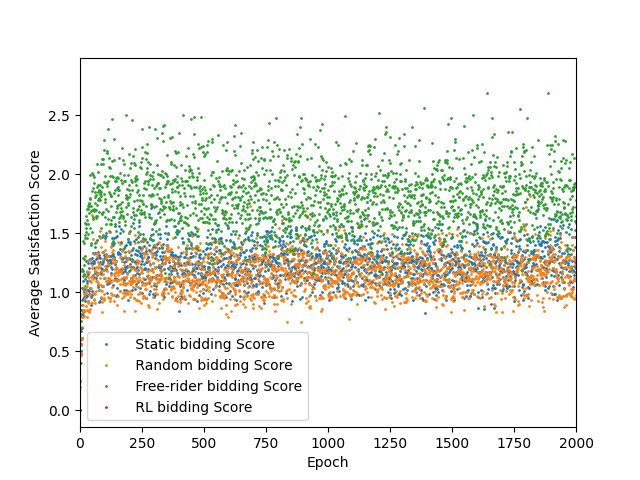

In [135]:
plot_satisfaction_scores_by_bidding_type(average_satisfaction_score_by_bidding_type, epochs_range=[0, 2000])


***

## 2. Heatmap of Throughput per Intersection

In [136]:
# Load relevant data: 
average_throughput_per_intersection = pd.read_csv('results/' + file_to_use + '/average_throughput_per_intersection.csv', header = None)

In [137]:
def plot_throughput_heatmap_average(data):
    """Creates a heatmap of the average throughput per intersection.
    Args:
        data (pd.DataFrame): The dataframe containing the data to plot
    """
    ax = sns.heatmap(data, annot=True)
    ax.set(xlabel='X coordinate', ylabel='Y coordinate',
        title='Average throughput per intersection')
    plt.show()
    plt.clf()
    

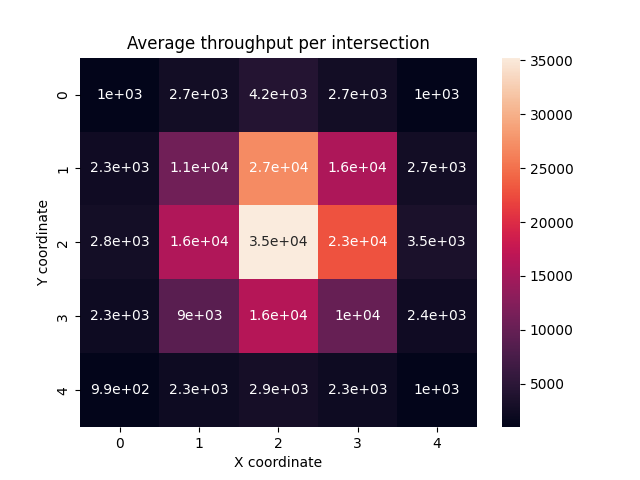

In [140]:
plot_throughput_heatmap_average(average_throughput_per_intersection)